**#Medical Prescription Data Extraction Using Multimodal LLMs**

Given a [Medical Presciption Images Dataset](https://www.kaggle.com/datasets/mehaksingal/illegible-medical-prescription-images-dataset) our aim is to extract structed data using an open-source Multimodal LLM.

For this task I'm using [**LLaVa 1.5-7B**](https://huggingface.co/llava-hf/llava-1.5-7b-hf) **(Multimodal LLM)**, we can also use these open source models to achieve this task.

1.   **BLIP-2**
2.   **MiniGPT-4**
3.   **PaliGemma 2 Mix** (Developed by Google, excels in OCR, visual question answering, image captioning and object detection)
4.   **BioMistral** (Excels in medical question-answering tasks, supports multilingual evaluations, pretrained on PubMed Central)
5.   **OpenBioLLM-70B**

***Note:*** *Change `Runtime -> Change runtime type -> T4 GPU` before executing the cells if running on Google Colab*

***1.   Install Dependencies***



In [1]:
!pip install transformers accelerate bitsandbytes sentencepiece
!pip install git+https://github.com/huggingface/transformers.git
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

***2.   Download Dataset***

You can download the dataset from this [link](https://www.kaggle.com/datasets/mehaksingal/illegible-medical-prescription-images-dataset) as a zip, extract the folder and place it in the same location as this jupyter notebook with the name `"data"`.

If you are not able to download it manually, you can do the same via executing code block below.

***(Remember to put secret key `KAGGLE_KEY` and `KAGGLE_USERNAME` in `.env` file to run the code given below. You can get both the keys in your Kaggle profile account)***


In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download mehaksingal/illegible-medical-prescription-images-dataset
!unzip "illegible-medical-prescription-images-dataset.zip"

Dataset URL: https://www.kaggle.com/datasets/mehaksingal/illegible-medical-prescription-images-dataset
License(s): MIT
Archive:  illegible-medical-prescription-images-dataset.zip
  inflating: data/1.jpg              
  inflating: data/10.jpg             
  inflating: data/100.jpg            
  inflating: data/101.jpg            
  inflating: data/102.jpg            
  inflating: data/103.jpg            
  inflating: data/104.jpg            
  inflating: data/105.jpg            
  inflating: data/106.jpg            
  inflating: data/107.jpg            
  inflating: data/108.jpg            
  inflating: data/109.jpg            
  inflating: data/11.jpg             
  inflating: data/110.jpg            
  inflating: data/111.jpg            
  inflating: data/112.jpg            
  inflating: data/113.jpg            
  inflating: data/114.jpg            
  inflating: data/115.jpg            
  inflating: data/116.jpg            
  inflating: data/117.jpg            
  inflating: data/118.j

***3.   Load the Data***

The given dataset contains **129 jpg images of handwritten medical prescriptions**.

Found 129 images.


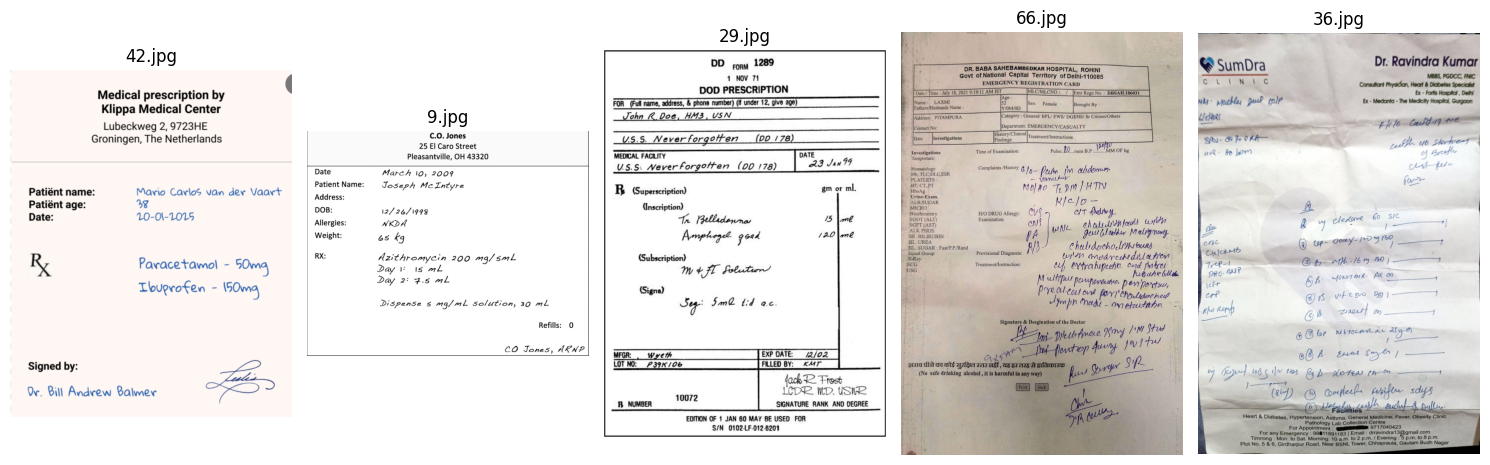

In [6]:
from PIL import Image
import random
import matplotlib.pyplot as plt

data_folder = "/content/data"
image_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.jpg')])

print(f"Found {len(image_files)} images.")

sample_images = random.sample(image_files, 5)

# Display in a grid
plt.figure(figsize=(15, 8))
for idx, filename in enumerate(sample_images):
    img_path = os.path.join("data", filename)
    img = Image.open(img_path).convert("RGB")

    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.title(filename)
    plt.axis("off")

plt.tight_layout()
plt.show()

***4.   Load Model and Define Prompt***

The output of the model is stored in a structed data format with the help of **prompt engineering**.

In [7]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
import torch

model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [8]:
prompt = """
You are a medical assistant AI. Given the following prescription image:

<image>

Extract ALL the following fields and return in **valid JSON** format:

{
  "Patient Name": "...",
  "Age": "...",
  "Gender": "...",
  "Date of appointment": "...",
  "Doctor's Name": "...",
  "Doctor's Qualification": "...",
  "Doctor's Registration Number": "...",
  "Hospital/Clinic Name": "...",
  "Hospital/Clinic Address": "...",
  "Hospital Phone Number": "...",
  "Symptoms / Chief Complaints": "...",
  "Diagnosis": "...",
  "Medicines": [
    {"name": "...", "dosage": "...", "frequency": "...", "route": "..."}
  ],
  "Lab Tests / Investigations": "...",
  "Special Instructions": "..."
}

If any field is missing or not visible, use null.
"""

In [9]:
torch.cuda.empty_cache()

***5.   Extract Information from Images using LLaVa, collect results as structed JSON and tabular CSV***

In [24]:
import pandas as pd
import json
from tqdm import tqdm

extracted_data = []

output_folder = "/content/extracted"
os.makedirs(output_folder, exist_ok=True)

#Loop through images, extract info and collect results
for filename in tqdm(image_files):
    image_path = os.path.join(data_folder, filename)
    img = Image.open(image_path).convert("RGB")

    # Prepare input
    device = "cuda" if torch.cuda.is_available() else "cpu"
    inputs = processor(text=prompt, images=img, return_tensors="pt").to(device)

    # Generate response
    output_ids = model.generate(**inputs, max_new_tokens=1024)
    response = processor.batch_decode(output_ids, skip_special_tokens=True)[0]
    response = response[response.index('If any field is missing or not visible, use null.'):]

    try:
        json_start = response.find("{")
        json_end = response.rfind("}") + 1
        json_str = response[json_start:json_end].strip()

        parsed = json.loads(json_str)
    except Exception as e:
        parsed = {}

    # Save individual JSON file
    json_path = os.path.join(output_folder, filename.replace(".jpg", ".json"))
    with open(json_path, "w") as f:
        json.dump(parsed, f, indent=2)

    fields = [
        "Patient Name", "Age", "Gender", "Date of appointment",
        "Doctor's Name", "Doctor's Qualification", "Doctor's Registration Number",
        "Hospital/Clinic Name", "Hospital/Clinic Address", "Hospital Phone Number",
        "Symptoms / Chief Complaints", "Diagnosis",
        "Medicines", "Lab Tests / Investigations", "Special Instructions"
    ]

    json_path = os.path.join(output_folder, filename.replace(".jpg", ".json"))
    if not os.path.exists(json_path):
        continue

    with open(json_path, "r") as f:
        parsed = json.load(f)

    row = {"filename": filename}
    for field in fields:
        value = parsed.get(field, "null")
        if isinstance(value, (list, dict)):
            value = json.dumps(value)
        row[field] = value if value != "" else "null"

    extracted_data.append(row)

    del inputs, output_ids, img
    torch.cuda.empty_cache()


# Create DataFrame
df = pd.DataFrame(extracted_data)

df.to_csv("Final_output.csv", index=False)

print("Final output saved as JSON and CSV")

  2%|▏         | 2/129 [00:21<19:32,  9.24s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


  4%|▍         | 5/129 [00:57<20:50, 10.09s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


  7%|▋         | 9/129 [02:00<24:53, 12.45s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 10%|█         | 13/129 [03:01<24:22, 12.61s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 11%|█         | 14/129 [03:15<25:28, 13.29s/it]

⚠️ JSON parse error: Expecting ',' delimiter: line 10 column 1 (char 229)


 12%|█▏        | 16/129 [03:37<21:28, 11.40s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 14%|█▍        | 18/129 [03:59<18:57, 10.25s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 16%|█▌        | 20/129 [04:19<17:21,  9.56s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 22%|██▏       | 28/129 [06:31<22:03, 13.10s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 23%|██▎       | 30/129 [06:52<18:18, 11.10s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 26%|██▌       | 33/129 [07:31<17:35, 11.00s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 30%|███       | 39/129 [09:28<29:04, 19.38s/it]

⚠️ JSON parse error: Expecting ',' delimiter: line 10 column 33 (char 302)


 31%|███       | 40/129 [09:46<27:44, 18.70s/it]

⚠️ JSON parse error: Expecting ',' delimiter: line 9 column 30 (char 250)


 34%|███▍      | 44/129 [10:28<17:08, 12.10s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 39%|███▉      | 50/129 [12:01<16:43, 12.70s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 41%|████      | 53/129 [12:43<15:18, 12.09s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 43%|████▎     | 56/129 [13:39<19:43, 16.21s/it]

⚠️ JSON parse error: Expecting ',' delimiter: line 9 column 30 (char 258)


 46%|████▌     | 59/129 [14:18<15:00, 12.87s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 52%|█████▏    | 67/129 [16:51<19:05, 18.48s/it]

⚠️ JSON parse error: Expecting ',' delimiter: line 13 column 1 (char 450)


 55%|█████▌    | 71/129 [17:48<13:07, 13.58s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 57%|█████▋    | 74/129 [18:26<10:39, 11.62s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 58%|█████▊    | 75/129 [18:28<07:47,  8.66s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 60%|█████▉    | 77/129 [18:47<07:22,  8.50s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 60%|██████    | 78/129 [18:49<05:34,  6.57s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 62%|██████▏   | 80/129 [19:30<10:59, 13.45s/it]

⚠️ JSON parse error: Expecting property name enclosed in double quotes: line 10 column 53 (char 324)


 66%|██████▌   | 85/129 [20:27<08:19, 11.36s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 67%|██████▋   | 87/129 [21:58<21:41, 31.00s/it]

⚠️ JSON parse error: Expecting ',' delimiter: line 20 column 2 (char 523)


 71%|███████   | 91/129 [22:56<10:36, 16.76s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 74%|███████▍  | 96/129 [24:24<09:13, 16.76s/it]

⚠️ JSON parse error: Expecting ',' delimiter: line 13 column 1 (char 345)


 80%|███████▉  | 103/129 [25:58<04:42, 10.86s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 83%|████████▎ | 107/129 [26:55<04:16, 11.65s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 84%|████████▍ | 109/129 [27:20<03:42, 11.14s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 87%|████████▋ | 112/129 [27:58<03:05, 10.93s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 94%|█████████▍| 121/129 [30:34<01:49, 13.72s/it]

⚠️ JSON parse error: Expecting value: line 1 column 1 (char 0)


 98%|█████████▊| 126/129 [32:08<00:52, 17.66s/it]

⚠️ JSON parse error: Expecting ',' delimiter: line 12 column 1 (char 348)


 99%|█████████▉| 128/129 [32:50<00:18, 18.94s/it]

⚠️ JSON parse error: Expecting ',' delimiter: line 10 column 33 (char 296)


100%|██████████| 129/129 [33:08<00:00, 15.42s/it]

⚠️ JSON parse error: Expecting ',' delimiter: line 12 column 1 (char 326)
✅ Final output saved as CSV and Excel.


***6.   (Optional) Zip the `extracted` folder to download easily***

In [25]:
!zip -r /content/extracted.zip /content/extracted

  adding: content/extracted/ (stored 0%)
  adding: content/extracted/46.json (stored 0%)
  adding: content/extracted/2.json (deflated 43%)
  adding: content/extracted/120.json (deflated 46%)
  adding: content/extracted/21.json (stored 0%)
  adding: content/extracted/38.json (deflated 43%)
  adding: content/extracted/99.json (stored 0%)
  adding: content/extracted/123.json (stored 0%)
  adding: content/extracted/9.json (deflated 44%)
  adding: content/extracted/57.json (deflated 46%)
  adding: content/extracted/91.json (stored 0%)
  adding: content/extracted/86.json (deflated 45%)
  adding: content/extracted/36.json (deflated 43%)
  adding: content/extracted/3.json (stored 0%)
  adding: content/extracted/32.json (stored 0%)
  adding: content/extracted/42.json (stored 0%)
  adding: content/extracted/72.json (deflated 49%)
  adding: content/extracted/62.json (deflated 46%)
  adding: content/extracted/17.json (stored 0%)
  adding: content/extracted/125.json (stored 0%)
  adding: content/ex